In [1]:
from google.colab import drive
drive.mount('/content/drive')


# Import necessary libraries
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop

Mounted at /content/drive


In [2]:
import os
import random
import shutil

# Direktori master dataset
base_dir = '/content/drive/My Drive/Capstone Project/Dataset/Master'
# Direktori hasil splitting
output_base_dir = '/content/drive/My Drive/Capstone Project/Dataset'

# Rasio splitting
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

class_data = {}

# Function to print the number of files in each subdirectory
def print_image_counts(base_dir):
    print(f"\nImage counts in '{base_dir}':")
    for split_name in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split_name)
        total_images = 0
        if os.path.exists(split_dir):
            for class_folder in os.listdir(split_dir):
                class_path = os.path.join(split_dir, class_folder)
                if os.path.isdir(class_path):
                    num_images = len(os.listdir(class_path))
                    total_images += num_images
                    print(f" - {split_name}/{class_folder}: {num_images} images")
        print(f"Total images in '{split_name}': {total_images}")

for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)

    if not os.path.isdir(class_path):
        continue

    files = [os.path.join(class_path, file) for file in os.listdir(class_path)
             if os.path.isfile(os.path.join(class_path, file))]
    class_data[class_folder] = files

# Print the number of images in each class directory before splitting
print("\nNumber of images in each class directory before splitting:")
for class_name, files in class_data.items():
    print(f" - {class_name}: {len(files)} images")

min_images = min(len(files) for files in class_data.values())


train_images = []
val_images = []
test_images = []

for class_folder, files in class_data.items():
    files = files[:min_images]

    random.shuffle(files)

    total_files = len(files)
    train_count = int(total_files * train_ratio)
    val_count = int(total_files * val_ratio)
    test_count = total_files - train_count - val_count

    train_images.extend(files[:train_count])
    val_images.extend(files[train_count:train_count + val_count])
    test_images.extend(files[train_count + val_count:])

print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of test images: {len(test_images)}")

os.makedirs(os.path.join(output_base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_base_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(output_base_dir, 'test'), exist_ok=True)

sorted_class_names = sorted(class_data.keys())
class_to_index = {class_name: idx for idx, class_name in enumerate(sorted_class_names)}

print("Class to Index Mapping:")
for class_name, idx in class_to_index.items():
    print(f"{idx}: {class_name}")

for split_name, split_images in [('train', train_images), ('val', val_images), ('test', test_images)]:
    for file_path in split_images:
        class_name = file_path.split(os.sep)[-2]

        class_index = class_to_index[class_name]

        target_dir = os.path.join(output_base_dir, split_name, f"{class_index}_{class_name}")
        os.makedirs(target_dir, exist_ok=True)

        target_path = os.path.join(target_dir, os.path.basename(file_path))
        shutil.copy2(file_path, target_path)  # DIKOPI BANG

print("Images have been moved to their respective directories.")

print_image_counts(output_base_dir)



Number of images in each class directory before splitting:
 - insang: 304 images
 - parang: 566 images
 - kawung: 564 images
 - tumpal: 309 images
 - mega_mendung: 603 images
 - sidoluhur: 325 images
Number of training images: 1272
Number of validation images: 270
Number of test images: 282
Class to Index Mapping:
0: insang
1: kawung
2: mega_mendung
3: parang
4: sidoluhur
5: tumpal
Images have been moved to their respective directories.

Image counts in '/content/drive/My Drive/Capstone Project/Dataset':
 - train/0_insang: 212 images
 - train/3_parang: 212 images
 - train/1_kawung: 212 images
 - train/5_tumpal: 212 images
 - train/2_mega_mendung: 212 images
 - train/4_sidoluhur: 212 images
Total images in 'train': 1272
 - val/0_insang: 45 images
 - val/3_parang: 45 images
 - val/1_kawung: 45 images
 - val/5_tumpal: 45 images
 - val/2_mega_mendung: 45 images
 - val/4_sidoluhur: 45 images
Total images in 'val': 270
 - test/0_insang: 47 images
 - test/3_parang: 47 images
 - test/1_kawung

In [3]:
# Load dataset
batch_size = 32
img_height = 224
img_width = 224

train_dir = os.path.join(output_base_dir, 'train')
val_dir = os.path.join(output_base_dir, 'val')
test_dir = os.path.join(output_base_dir, 'test')

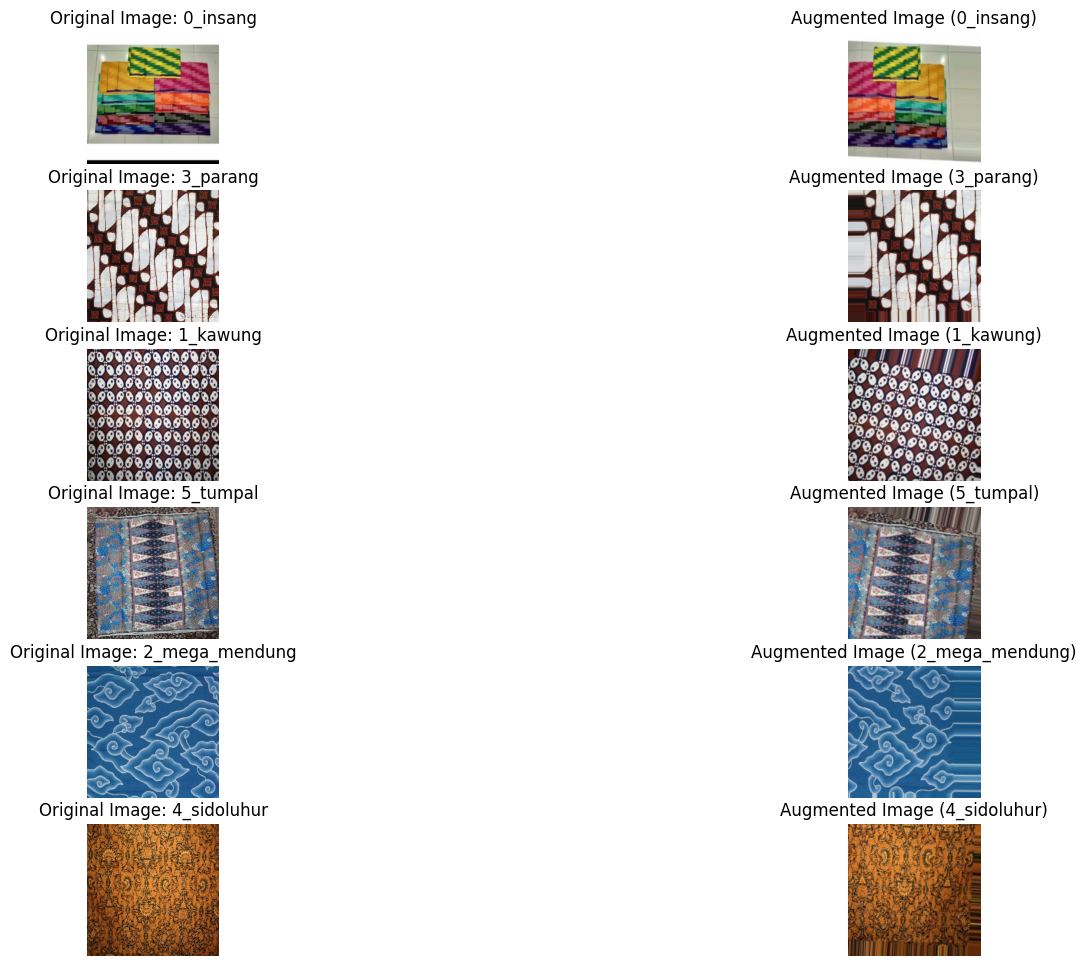

In [4]:
# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

plt.figure(figsize=(18, 12))

class_names = os.listdir(train_dir)

for idx, class_name in enumerate(class_names):
    class_dir = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    selected_image = random.choice(image_files)
    sample_image_path = os.path.join(class_dir, selected_image)

    original_img = load_img(sample_image_path, target_size=(img_height, img_width))
    original_img_array = img_to_array(original_img)

    plt.subplot(len(class_names), 2, idx * 2 + 1)
    plt.imshow(original_img_array / 255.0)  # Normalize for display only
    plt.title(f"Original Image: {class_name}")
    plt.axis("off")

    # Generate and display augmented images
    img_batch = np.expand_dims(original_img_array, axis=0)
    augmented_images = next(train_datagen.flow(img_batch, batch_size=1))[0]

    plt.subplot(len(class_names), 2, idx * 2 + 2)
    plt.imshow(augmented_images)
    plt.title(f"Augmented Image ({class_name})")
    plt.axis("off")

val_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [5]:
def debug_directory_content(directory):
    print(f"Inspecting Directory: {directory}")
    if not os.path.exists(directory):
        print(f"Directory does not exist: {directory}")
        return
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_count = len([img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"Class: {class_name}, Images: {image_count}")
        else:
            print(f"Invalid file in directory: {class_name}")

# Debug each dataset directory
print("### Train Directory ###")
debug_directory_content(train_dir)
print("\n### Validation Directory ###")
debug_directory_content(val_dir)
print("\n### Test Directory ###")
debug_directory_content(test_dir)

### Train Directory ###
Inspecting Directory: /content/drive/My Drive/Capstone Project/Dataset/train
Class: 0_insang, Images: 212
Class: 3_parang, Images: 212
Class: 1_kawung, Images: 212
Class: 5_tumpal, Images: 212
Class: 2_mega_mendung, Images: 212
Class: 4_sidoluhur, Images: 212

### Validation Directory ###
Inspecting Directory: /content/drive/My Drive/Capstone Project/Dataset/val
Class: 0_insang, Images: 45
Class: 3_parang, Images: 45
Class: 1_kawung, Images: 45
Class: 5_tumpal, Images: 45
Class: 2_mega_mendung, Images: 45
Class: 4_sidoluhur, Images: 45

### Test Directory ###
Inspecting Directory: /content/drive/My Drive/Capstone Project/Dataset/test
Class: 0_insang, Images: 47
Class: 3_parang, Images: 47
Class: 1_kawung, Images: 47
Class: 5_tumpal, Images: 47
Class: 2_mega_mendung, Images: 47
Class: 4_sidoluhur, Images: 47


In [6]:
# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Check the number of images in each generator
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

Found 1020 images belonging to 6 classes.
Found 252 images belonging to 6 classes.
Found 282 images belonging to 6 classes.
Training samples: 1020
Validation samples: 252


In [7]:
# Check validation generator
print("\nValidation Data Check:")
try:
    val_sample = next(val_generator)
    print(f"Loaded validation batch shape: {val_sample[0].shape}, Labels shape: {val_sample[1].shape}")
except Exception as e:
    print("Error with validation generator:", e)



Validation Data Check:
Loaded validation batch shape: (32, 224, 224, 3), Labels shape: (32, 6)


In [8]:
# Number of classes
num_classes = train_generator.num_classes

# Load the VGG16 model without the top
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = False

model = Sequential()

# Add VGG16 sebagai base model
model.add(vgg_base)
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

# output layer
model.add(Dense(num_classes, activation='softmax'))

# Build the model
model.build(input_shape=(None, 224, 224, 3))

# Fine-tune the last 3 layers
for layer in vgg_base.layers[-3:]:
    layer.trainable = True

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,321,030 (62.26 MB)

 Trainable params: 6,325,830 (24.13 MB)

 Non-trainable params: 9,995,200 (38.13 MB)

In [9]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
class CustomStopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        loss = logs.get('loss')

        # Check if accuracy > 0.9 and loss < 0.1
        if accuracy > 0.9 and loss < 0.1:
            print(f"\nStopping training as accuracy is {accuracy:.4f} and loss is {loss:.4f}.")
            self.model.stop_training = True

In [11]:
epochs = 30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/32 ━━━━━━━━━━━━━━━━━━━━ 10s 509ms/step - accuracy: 0.3106 - loss: 1.8560

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4687 - loss: 1.4479 - val_accuracy: 0.7619 - val_loss: 0.7381
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 648ms/step - accuracy: 0.8543 - loss: 0.4410 - val_accuracy: 0.8016 - val_loss: 0.5831
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 684ms/step - accuracy: 0.9020 - loss: 0.3250 - val_accuracy: 0.8571 - val_loss: 0.5243
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 697ms/step - accuracy: 0.9298 - loss: 0.2459 - val_accuracy: 0.8651 - val_loss: 0.4573
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 654ms/step - accuracy: 0.9465 - loss: 0.2047 - val_accuracy: 0.8810 - val_loss: 0.3907
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 649ms/step - accuracy: 0.9329 - loss: 0.2011 - val_accuracy: 0.8849 - val_loss: 0.4478
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 661ms/step - accuracy: 0.9716 - loss: 0.1351 - val_accuracy: 0.8690 - val_loss: 0.4210
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 658ms/step - accuracy: 0.9513 - loss: 0.1538 - val_accuracy: 0.8929 -

9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9336 - loss: 0.2421
Test Accuracy: 91.84%


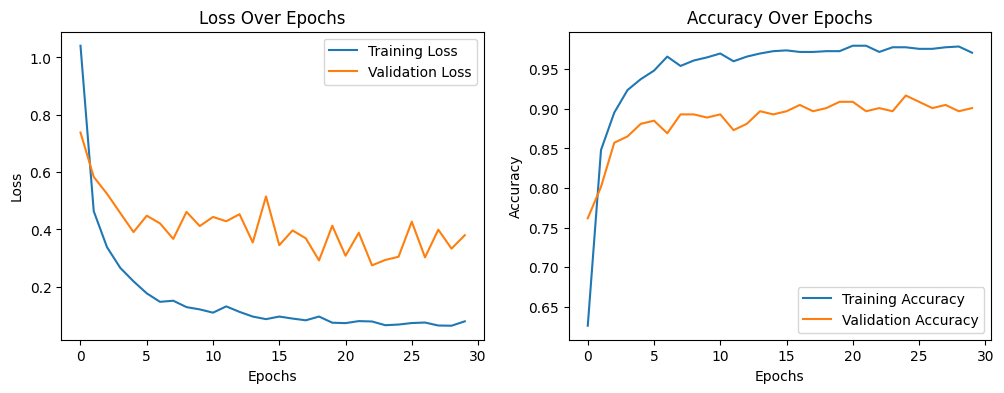

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()

In [18]:
# Save the model
model.save(base_dir + 'model/main_model.h5')
import joblib

# Save the model
joblib.dump(model, base_dir + 'model/main_model.sav')

['/content/drive/My Drive/Capstone Project/Dataset/Mastermodel/main_model.sav']

In [19]:
# Load kembali model terbaik untuk prediksi
# Prediksi contoh gambar
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

# Lokasi folder testing
TEST_DIR = '/content/drive/My Drive/Capstone Project/Dataset/test'

# Lokasi folder model
MODEL_DIR = base_dir + 'model/main_model.h5'

save_path = base_dir + 'model/main_model.h5'

# Memuat model terbaik
best_model = load_model(save_path)

# Mendapatkan daftar kelas dari nama subfolder dalam test_dir
classes = [subdir for subdir in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, subdir))]
print(classes)
# Melakukan pengujian untuk setiap kelas
for class_name in classes:
    class_dir = os.path.join(TEST_DIR, class_name)
    image_files = [file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Mengambil satu gambar secara acak dari setiap kelas
    if len(image_files) > 0:
        random_image = random.choice(image_files)
        image_path = os.path.join(class_dir, random_image)

        # Memuat dan memproses gambar
        # Change target_size to (224, 224)
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Memprediksi kelas gambar
        prediction = best_model.predict(img_array)
        predicted_class_index = np.argmax(prediction)
        predicted_class = classes[predicted_class_index]

        # Menampilkan hasil prediksi
        print(f"Image: {random_image}")
        print(f"True Class: {class_name}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {np.max(prediction):.2%}")
        print("---")

['0_insang', '3_parang', '1_kawung', '5_tumpal', '2_mega_mendung', '4_sidoluhur']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image: insang.118.jpg
True Class: 0_insang
Predicted Class: 0_insang
Confidence: 98.62%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: 2_jpg.rf.8b592d6b5a8d004b6b95db1e75ec0c6b.jpg
True Class: 3_parang
Predicted Class: 5_tumpal
Confidence: 76.07%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: test.kawung.12.jpg
True Class: 1_kawung
Predicted Class: 3_parang
Confidence: 99.89%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: tumpal.94.jpg
True Class: 5_tumpal
Predicted Class: 4_sidoluhur
Confidence: 99.93%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: 7_jpg.rf.f0bf2335e54022b08c434a7c490610fc.jpg
True Class: 2_mega_mendung
Predicted Class: 1_kawung
Confidence: 59.64%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image: sidoluhur.36.jpg
True Class: 4_sidoluhur
Predicted Class: 2_mega_mendung
Confidence: 93.19%
---
